# Glaucoma Prediction
Glaucoma is an eye disease and it causes permanent vision damage when the diagnosis is made late.

In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive'

/content/drive/My Drive


In [ ]:
root_path = "/content/drive/My Drive/"

# Libraries

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tensorflow.keras.optimizers import Adam
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.models  import load_model
import warnings
import os
import shutil
import itertools
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
datasetFolderName=root_path+'KFoldACRIMA'
MODEL_FILENAME=root_path+"model_cv.h5"
sourceFiles=[]
classLabels=['glaucoma', 'healthy']
X=[]
Y=[]

img_rows, img_cols =  100, 100 # input image dimensions
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'

In [ ]:
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score


# First, check if test folder is empty or not, if not transfer all existing files to train.

In [ ]:
transferAllClassBetweenFolders('test', 'train', 1.0)

No file moved. Source empty!
No file moved. Source empty!


# Now, split some part of train data into the test folders.

In [ ]:
transferAllClassBetweenFolders('train', 'test', 0.20)

In [ ]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)

In [ ]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

In [ ]:
X=np.asarray(X)
Y=np.asarray(Y)

In [ ]:
# Note that, this model structure is a very basic one. To achieve better performance, you should change the model structure and hyperparameters according to your needs and data.
batch_size = 512
epoch=100
activationFunction='elu'
def getModel():
    vgg16_model = tf.keras.applications.vgg16.VGG16()
    model = Sequential()
    for layer in vgg16_model.layers[:-1]:
      model.add(layer)
    for layer in model.layers:
      layer.trainable = False

    return model

model=getModel()

553476096/553467096 [==============================] - 16s 0us/step


In [ ]:
model.add(Dense(2, activation='softmax'))
model.compile(Adam(learning_rate=.0001), loss='binary_crossentropy', metrics=['accuracy'])

# **Stratified K-Fold Cross validation**

In [ ]:
# ===============Stratified K-Fold======================
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])
        
    train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      zoom_range=0.20,
                      fill_mode="nearest")
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode=None,  # only data, no labels
        shuffle=False)   
   
    # fit model
    history=model.fit(train_generator, 
                        epochs=50)
    
    predictions = model.predict_generator(validation_generator, verbose=1)
    yPredictions = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

Results for fold 1
Found 374 images belonging to 2 classes.
Found 187 images belonging to 2 classes.
Epoch 1/50


InvalidArgumentError: ignored

# Test phase

In [ ]:
print("==============TEST RESULTS============")
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False) 
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)
model.save(MODEL_FILENAME)

==============TEST RESULTS============
Found 139 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Accuracy  : 0.9568345323741008
Precision : 0.9570662114376295
f1Score : 0.9567480193060741
[[76  2]
 [ 4 57]]


In [ ]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
  
  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],
            horizontalalignment ="center",
            color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(true_classes, yPredictions)

In [ ]:
cm_plot_labels = ['Glaucoma', 'Healthy']

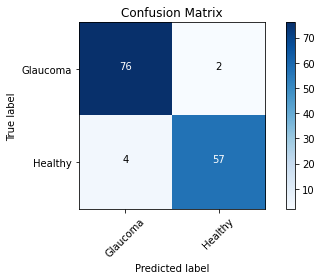

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels,title ='Confusion Matrix')